In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

turnOver = datastore.getTurnover()

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 6289
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [15]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh, 
                     transTo, transFrom, 
                     flow, capTo, capFrom, exchangeFrom, exchangeTo,
                     temp_pen, wind_velocities, hydroReservoirs, turnOver], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])

dataset.rename(columns = {"spotPrice" : "y"}, inplace=True)
dataset.insert(0, "unique_id", 1)
dataset.insert(0, "ds", dataset.index)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54024 entries, 2018-01-01 00:00:00 to 2024-02-29 23:00:00
Columns: 115 entries, ds to hour_23
dtypes: datetime64[ns](1), float64(61), int32(1), int64(2), uint8(50)
memory usage: 31.6 MB


In [45]:
target = dataset["y"].to_frame()
features = dataset.drop(columns=["y"])

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

train_df = dataset.iloc[:train_split_index]
val_df = dataset.iloc[train_split_index:val_split_index]
test_df = dataset.iloc[val_split_index:test_split_index]



import torch

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Your Device is {device}.")

h = val_df.ds.nunique()

Your Device is cuda.


In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca = pca.fit(dataset)

num_comps = len(pca.explained_variance_ratio_)
# plt.figure(figsize=(10, 6))

# plt.bar(np.arange(num_comps), pca.explained_variance_ratio_)
# plt.plot(np.arange(num_comps), np.cumsum(pca.explained_variance_ratio_), c='r')


In [ ]:
from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

train, *_ = TimeSeriesDataset.from_df(train_df)
config = dict(max_steps=2, val_check_steps=1, input_size=-1, encoder_hidden_size=1)
model = AutoLSTM(h=24*5, config=config)
model.fit(dataset=train)

In [17]:
futr_exog_list = dataset.iloc[:, 63:].columns.to_list()
past_cov_list = dataset.iloc[:, 2:63].columns.to_list()

# holdout_df = dataset.loc['2024-02-25':'2024-02-29']
# dataset = dataset.drop(holdout_df.index)

In [44]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAE, MSE

horizon = 24 * 5

nf = NeuralForecast(
    models = [LSTM(h = horizon, 
                input_size = -1, 
                
                max_steps= 55,
                scaler_type = "minmax",
                batch_size = 32,
                
                loss=MAE(),
                
                futr_exog_list = futr_exog_list,
                hist_exog_list = past_cov_list,
                
                encoder_n_layers= 1, 
                encoder_hidden_size = 32,
                
                context_size = 10, 
                
                decoder_hidden_size = 32,   
                decoder_layers= 1, 
                )], freq = "H"
)

nf.fit(df=train_df, verbose = True)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [46]:
cv_df = nf.cross_validation(test_df, step_size= 1, n_windows=1, verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

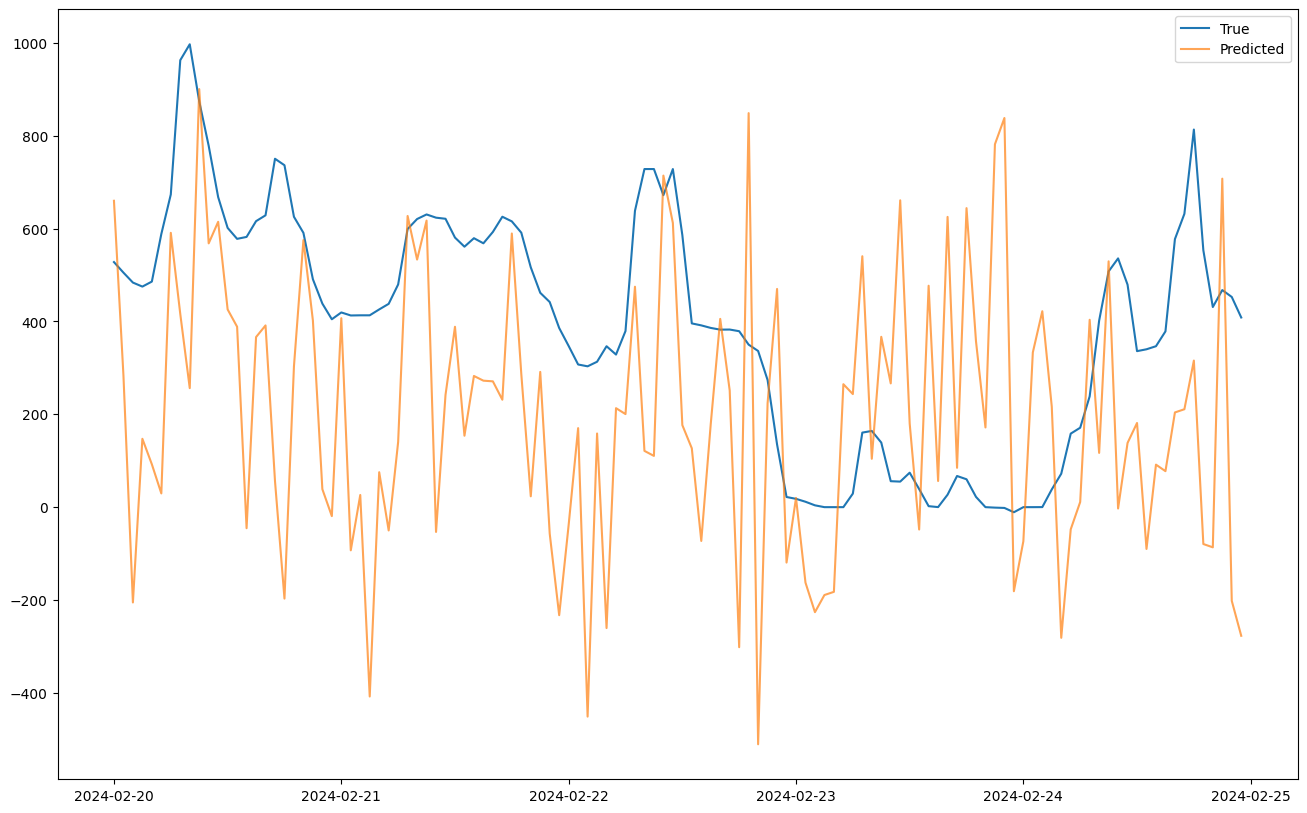

In [61]:
from neuralforecast.losses.numpy import (
    mae, mse, rmse,              # unscaled errors
    mape, smape,                 # percentage errors
)

y_hat = nf.predict(futr_df = test_df)

y_hat.LSTM.to_numpy().shape

mae = mae(y_hat.LSTM.to_numpy(), dataset[-horizon:].y.to_numpy())
mse = mse(y_hat.LSTM.to_numpy(), dataset[-horizon:].y.to_numpy())
rmse = rmse(y_hat.LSTM.to_numpy(), dataset[-horizon:].y.to_numpy())
mape = mape(y_hat.LSTM.to_numpy(), dataset[-horizon:].y.to_numpy())
smape = smape(y_hat.LSTM.to_numpy(), dataset[-horizon:].y.to_numpy())

plt.figure(figsize=(16, 10))
plt.plot(dataset[-horizon:].ds, dataset[-horizon:].y, label = "True")
plt.plot(y_hat.ds, y_hat.LSTM, label = "Predicted", alpha = 0.7)
plt.legend()
plt.show()

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import MAE, MSE

horizon = 24 * 5

nf = NeuralForecast(
    models = [LSTM(h = horizon, 
                input_size = horizon * 5, 
                
                max_steps= 30,
                scaler_type = "minmax",
                batch_size = 32,
                
                loss=MAE(),
                
                futr_exog_list = futr_exog_list,
                hist_exog_list = past_cov_list,
                
                encoder_n_layers=1, 
                encoder_hidden_size = 16,
                
                context_size = 10, 
                
                decoder_hidden_size = 16,   
                decoder_layers=1, 
                )], freq = "H"
)

nf.fit(df=train_df, verbose = True)

In [ ]:
y_hat = nf.predict(futr_df=val_df)

